In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2D Unet

reference: https://arxiv.org/pdf/1505.04597.pdf
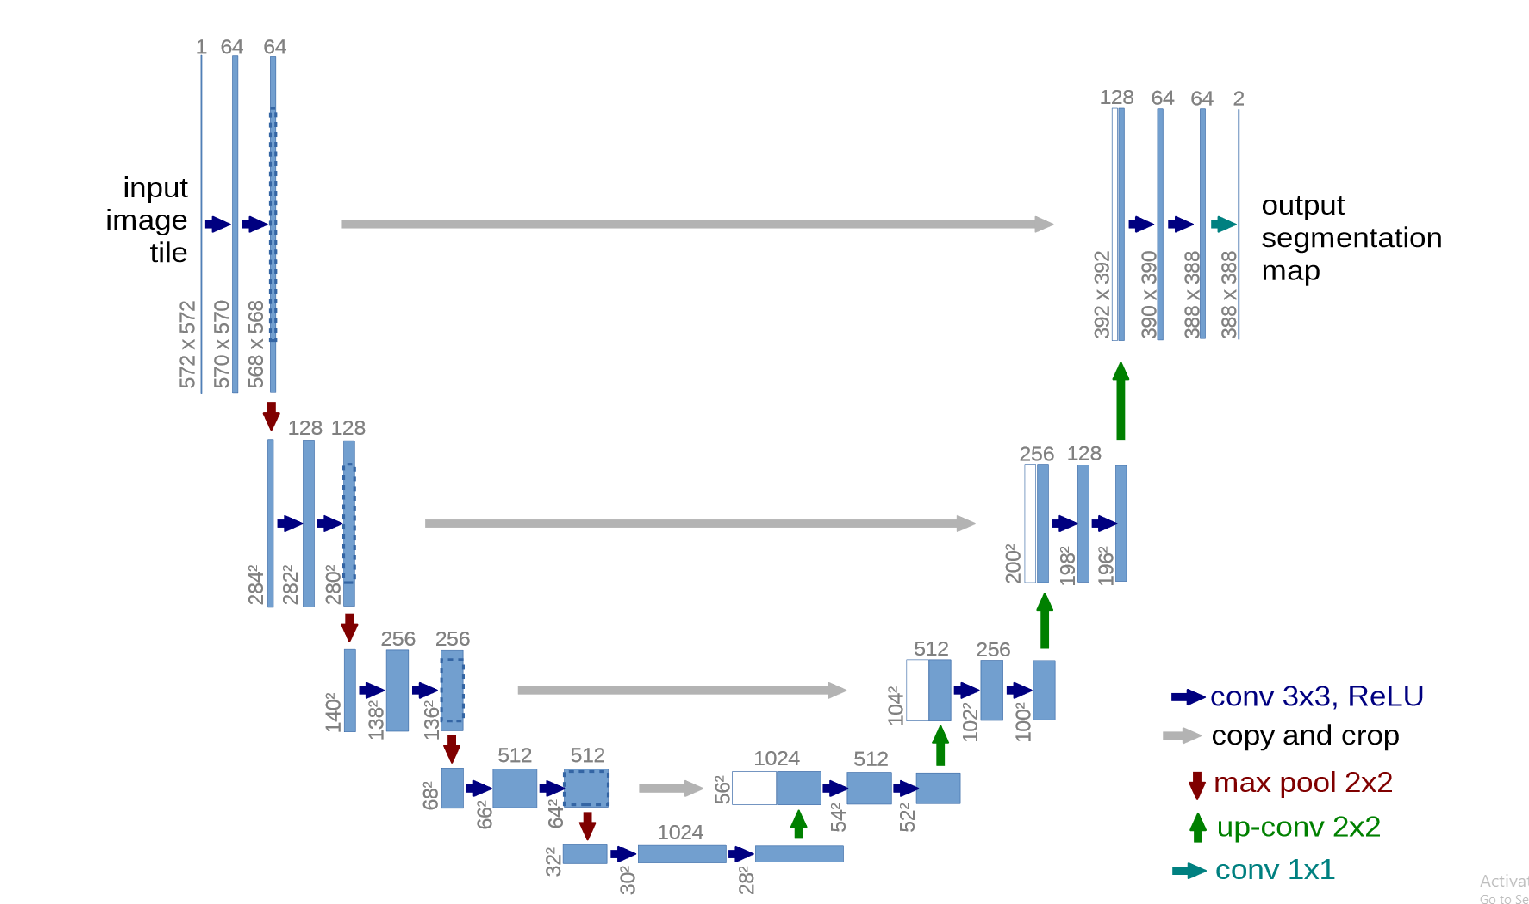

    Note: numbers need to be tuned for 512x512 images, paper uses 572x572 images

In [2]:
# convs: 3x3 unpadded, relu
# maxpooling: 2x2, stride = 2
#     double number of features after every maxpooling
# up-convolution: upsamping 2x2, followed by 2x2 convolution
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Cropping2D, Concatenate, Dropout

def Unet2D(input_size = (512,512,1)):
    # Contracting Path
    inputs = Input(input_size)
    conv_1 = Conv2D(32,(3,3), activation='relu', padding='same')(inputs)
    conv_1 = Conv2D(32,(3,3), activation='relu', padding='same')(conv_1)
    maxP_1 = MaxPool2D(pool_size=(2,2), strides=2)(conv_1)

    conv_2 = Conv2D(64,(3,3), activation='relu', padding='same')(maxP_1)
    conv_2 = Conv2D(64,(3,3), activation='relu', padding='same')(conv_2)
    maxP_2 = MaxPool2D(pool_size=(2,2), strides=2)(conv_2)

    conv_3 = Conv2D(128,(3,3), activation='relu', padding='same')(maxP_2)
    conv_3 = Conv2D(128,(3,3), activation='relu', padding='same')(conv_3)
    maxP_3 = MaxPool2D(pool_size=(2,2), strides=2)(conv_3)

    conv_4 = Conv2D(256,(3,3), activation='relu', padding='same')(maxP_3)
    conv_4 = Conv2D(256,(3,3), activation='relu', padding='same')(conv_4)
    drop_4 = Dropout(.5)(conv_4)
    maxP_4 = MaxPool2D(pool_size=(2,2), strides=2)(drop_4)

    conv_5 = Conv2D(512,(3,3), activation='relu', padding='same')(maxP_4)
    conv_5 = Conv2D(512,(3,3), activation='relu', padding='same')(conv_5)
    drop_5 = Dropout(.3)(conv_5)
    
    # Expansive Path
    upSamp_6 = UpSampling2D(size=(2,2))(drop_5)
    upSamp_6 = Conv2D(256,(2,2), padding = 'same')(upSamp_6)
    crop_6 = Cropping2D()(conv_4)
    combine_6 = Concatenate()([crop_6,upSamp_6])
    conv_6 = Conv2D(256,(3,3), activation='relu', padding='same')(combine_6)
    conv_6 = Conv2D(256,(3,3), activation='relu', padding='same')(conv_6)
    
    upSamp_7 = UpSampling2D(size=(2,2))(conv_6)
    upSamp_7 = Conv2D(128,(2,2), padding = 'same')(upSamp_7)
    crop_7 = Cropping2D()(conv_3)
    combine_7 = Concatenate()([crop_7,upSamp_7])
    conv_7 = Conv2D(128,(3,3), activation='relu', padding='same')(combine_7)
    conv_7 = Conv2D(128,(3,3), activation='relu', padding='same')(conv_7)
    
    upSamp_8 = UpSampling2D(size=(2,2))(conv_7)
    upSamp_8 = Conv2D(64,(2,2), padding = 'same')(upSamp_8)
    crop_8 = Cropping2D()(conv_2)
    combine_8 = Concatenate()([crop_8,upSamp_8])
    conv_8 = Conv2D(64,(3,3), activation='relu', padding='same')(combine_8)
    conv_8 = Conv2D(64,(3,3), activation='relu', padding='same')(conv_8)
    
    upSamp_9 = UpSampling2D(size=(2,2))(conv_8)
    upSamp_9 = Conv2D(32,(2,2), padding = 'same')(upSamp_9)
    crop_9 = Cropping2D()(conv_1)
    combine_9 = Concatenate()([crop_9,upSamp_9])
    conv_9 = Conv2D(32,(3,3), activation='relu', padding='same')(combine_9)
    conv_9 = Conv2D(32,(3,3), activation='relu', padding='same')(conv_9)
    outputs = Conv2D(1,(1,1), activation='sigmoid', padding='same')(conv_9)
        
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

x_2d = Unet2D()


In [3]:
print(x_2d.summary(line_length = 150))

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 512, 512, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, 512, 512, 32)             320               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                                (None, 512, 512, 32)          

# Define Image Generator

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
heart_dir = './LCTSC/heart_2d/'
eso_dir = './LCTSC/eso_2d/'
lungR_dir = './LCTSC/lungR_2d/'
lungL_dir = './LCTSC/lungL_2d/'
spine_dir = './LCTSC/spine_2d/'

label_heart = 'Heart_'
label_eso = '_Esophagus_'
label_lungR = 'Lung_R_'
label_lungL = '_Lung_L_'
label_spine = '_SpinalCord_'

data_dir = './LCTSC/data_2d/'

seg_dir = heart_dir
label = label_heart

seg_info = (seg_dir, label)

def image_generator(files, seg_info, batch_size = 10):    
    while True: 
        seg_dir,label = seg_info
        #extract a random batch 
        batch = np.random.choice(files, size = batch_size)    

        #variables for collecting batches of inputs and outputs 
        batch_x = []
        batch_y = []

        for f in batch:
            #get the Masks and CT scans. Note that they are stored as NP arrays
            data = np.load(data_dir + f)
            mask = np.load(seg_dir + f.split('_')[0] + label + f[-7:-4] + '.npy')

            batch_y.append(mask)
            batch_x.append(data)

        #preprocess a batch of images and masks 
        batch_x = np.asarray(batch_x)
        batch_x = batch_x.reshape((batch_x.shape[0],batch_x.shape[1],batch_x.shape[2],1))
        if np.amax(batch_x) > 0:
            batch_x = batch_x / np.amax(batch_x)

        batch_y = np.asarray(batch_y)
        batch_y = batch_y.reshape((batch_y.shape[0],batch_y.shape[1],batch_y.shape[2],1))
        if np.amax(batch_y) > 0:
            batch_y = batch_y / np.amax(batch_y)
        
        batch_x = np.nan_to_num(batch_x)
        batch_y = np.nan_to_num(batch_y)
        
        yield (batch_x, batch_y)  


# Load Data 

In [7]:
data_files = sorted(os.listdir(data_dir))

test_files = []
train_files = []
# keep first 15 datasets as test
for f in data_files:
    if int(f.split('_')[0]) < 15:
        test_files.append(f)
    else:
        train_files.append(f)

        
train_files, val_files = train_test_split(train_files, test_size = .2, random_state = 42)


In [8]:
# get only data that contains heart
cut_train_files =[]
empty_train_files =[]

for f in train_files:
    mask = np.load(seg_dir + f.split('_')[0] + label + f[-7:-4] + '.npy')
    if np.sum(np.concatenate(mask)) > 0:
        cut_train_files.append(f)
    else:
        empty_train_files.append(f)

cut_val_files = []
empty_val_files = []

for f in val_files:
    mask = np.load(seg_dir + f.split('_')[0] + label + f[-7:-4] + '.npy')
    if np.sum(np.concatenate(mask)) > 0:
        cut_val_files.append(f)
    else:
        empty_val_files.append(f) 
        
cut_test_files = []
empty_test_files = []

for f in test_files:
    mask = np.load(seg_dir + f.split('_')[0] + label + f[-7:-4] + '.npy')
    if np.sum(np.concatenate(mask)) > 0:
        cut_test_files.append(f)
    else:
        empty_test_files.append(f)

In [9]:
import random
print('Train Set')
print('labeled images:',len(cut_train_files), '   no-label images:', len(empty_train_files), '   total images:', len(train_files))
comb_train_files = []
empty = random.sample(empty_train_files, len(cut_train_files))
comb_train_files = cut_train_files + empty
print('Total number of frames to train on:', len(comb_train_files), '\n')

print('Validation Set')
print('labeled images:',len(cut_val_files), '   no-label images:', len(empty_val_files), '   total images:', len(val_files), '\n')
comb_val_files = []
empty = random.sample(empty_val_files, len(cut_val_files))
comb_val_files = cut_val_files + empty

print('Test Set')
print('labeled images:',len(cut_test_files), '   no-label images:', len(empty_test_files), '   total images:', len(test_files), '\n')

comb_test_files = []
empty = random.sample(empty_test_files, len(cut_test_files))
comb_test_files = cut_test_files + empty


Train Set
labeled images: 1254    no-label images: 4431    total images: 5685
Total number of frames to train on: 2508 

Validation Set
labeled images: 301    no-label images: 1121    total images: 1422 

Test Set
labeled images: 410    no-label images: 1426    total images: 1836 



# Train Model

In [ ]:
# define generators
batch_size = 5
train_gen = image_generator(comb_train_files,seg_info, batch_size = batch_size)

val_gen = image_generator(comb_val_files, seg_info, batch_size = batch_size)


In [ ]:
def dice_loss(y_true, y_pred):
    
    y_true = y_true[:,:,:,0]
    y_pred = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return 1 - (numerator + 1) / (denominator + 1)

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
# Compile and train the model, using generator, with call back
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "lung_weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

x_2d.save_weights(checkpoint_path.format(epoch=0))

# FULL data
x_2d.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', mean_iou, dice_loss])


train_steps = len(comb_train_files) // batch_size
val_steps = len(comb_val_files) // batch_size

history = x_2d.fit(train_gen, steps_per_epoch = train_steps, validation_data = val_gen, 
                   validation_steps = val_steps, epochs=2, shuffle=True, callbacks = [cp_callback])

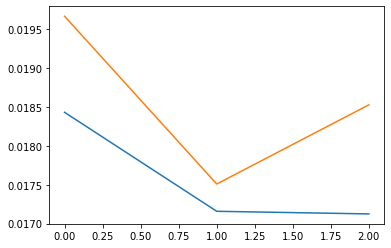

In [54]:
import matplotlib.pyplot as plt
history.history.keys()
epochs = [x for x in range(3)]
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

# Load Weights, Visualize and Save Predictions

In [26]:
import scipy

x_2d.load_weights('./Unet_binary_cross_entropy.h5')


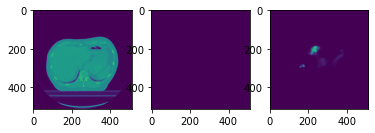

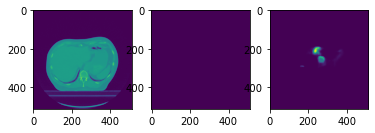

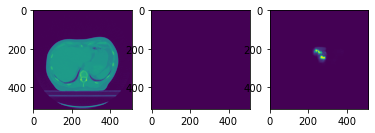

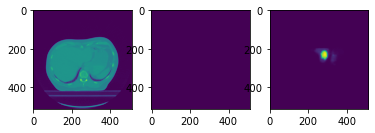

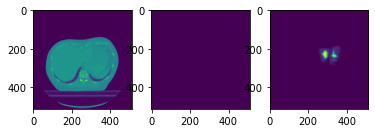

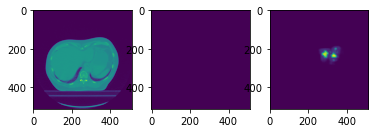

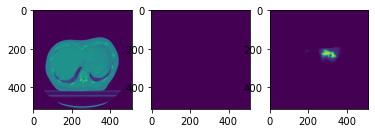

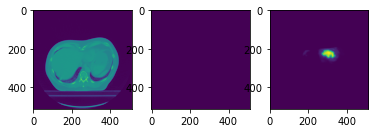

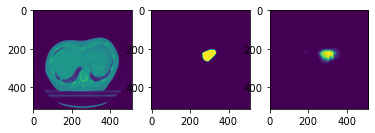

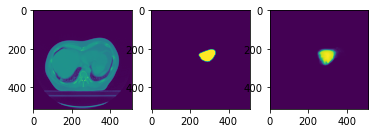

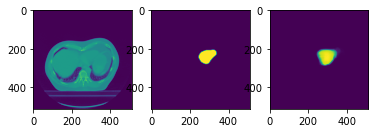

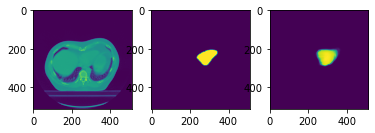

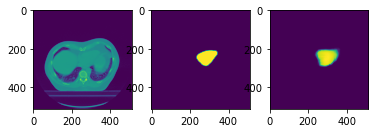

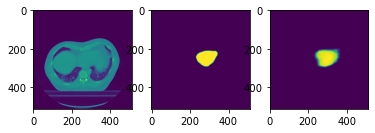

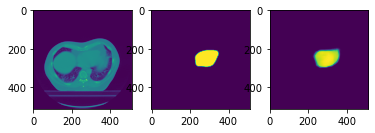

In [27]:
# ALL SLICES

import matplotlib.pyplot as plt

pred_masks = []
true_masks = []

for f in test_files[25:40]:
    #if '12_' in f:
    savename_pred = './predictions_heart/' + f[:-4] + '_PREDICTION.png'
    savename_mask = './predictions_heart/' + f[:-4] + '_MASK.png'
    data = np.load(data_dir + f)
    mask = np.load(heart_dir + f.split('_')[0] + 'Heart_' + f[-7:-4] + '.npy')

    # preprocess data and mask
    data = np.asarray(data)
    data = data.reshape((1,data.shape[0],data.shape[1],1))
    if np.amax(data) > 0:
        data = data / np.amax(data)

    # Predict
    pred_mask = x_2d.predict(data)
    pred_masks.append(pred_mask[0,:,:,0])
    true_masks.append(mask)


    # Save Prediction and Mask
    plt.imsave(fname = savename_pred, arr = pred_mask[0,:,:,0], vmin = 0.0, vmax = 1.0)
    plt.imsave(fname = savename_mask, arr = mask, vmin = 0.0, vmax = 1.0)

    # visualize
    plt.subplot(131)
    plt.imshow(data[0,:,:,0])
    plt.subplot(132)
    plt.imshow(mask)
    plt.subplot(133)
    plt.imshow(pred_mask[0,:,:,0])
    plt.show()
    

In [76]:
x_2d.save_weights('Unet_binary_cross_entropy.h5')